In [92]:
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [93]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

In [94]:
image = cv2.imread('img.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

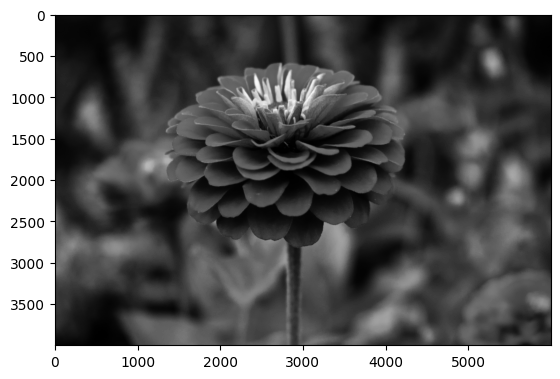

In [95]:
plt.imshow(image_gray, cmap="gray")

Функция для оценки качества фильтрации

In [96]:
def evaluate_filter(original, filtered):
    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered)
    return psnr_value, ssim_value

1. Зашумить изображение при помощи шума гаусса, постоянного шума.

In [97]:
# save noises images
images_noise = {}

# create gauss noise
mean = 0
stddev = 180 # 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)

# create uniform noise
a, b = -60, 60 # -25, 25
noise_uniform = np.random.uniform(a, b, image_gray.shape)

# create gausse + uniform noise
noise_gauss_uniform = noise_gauss.astype(np.int16) + noise_uniform

# original + gauss noise
image_noise_gauss = np.clip(image_gray.astype(np.int16) + noise_gauss.astype(np.int16), 0, 255).astype(np.uint8)
images_noise[f'Gaussian noise (σ={stddev})'] = image_noise_gauss

# original + uniform noise
image_noise_uniform = np.clip(image_gray.astype(np.int16) + noise_uniform.astype(np.int16), 0, 255).astype(np.uint8)
images_noise[f'Uniform noise (a={a}, b={b})'] = image_noise_uniform

# original + gauss noise + uniform noise
image_noise_gauss_uniform = np.clip(image_gray.astype(np.int16) + noise_gauss_uniform.astype(np.int16), 0, 255).astype(np.uint8)
images_noise[f'Gaussian noise + Uniform noise'] = image_noise_gauss_uniform

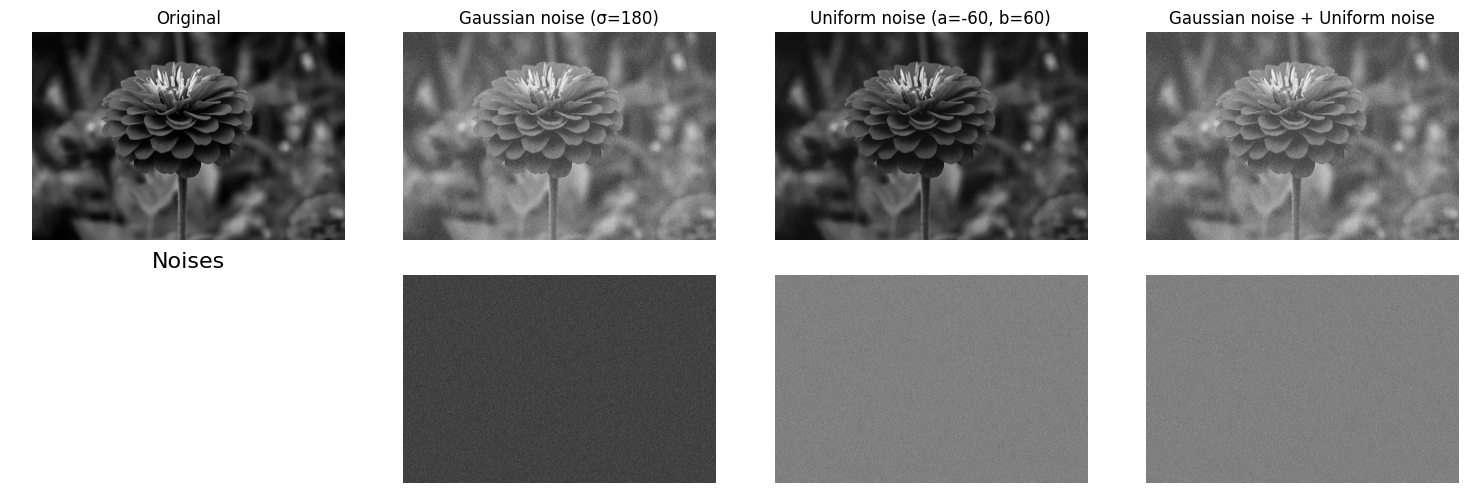

Original vs Original with gaussian noise.
	PSNR: 8.427289555450164, SSIM: 0.012667570113055752
Original vs Original with uniform noise.
	PSNR: 18.04668776209911, SSIM: 0.07705154336715596
Original vs Original with gaussian & uniform noises.
	PSNR: 8.177973451157834, SSIM: 0.010791653286376117


In [98]:

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for col, key in enumerate(images_noise, start=1):
    axes[0, col].imshow(images_noise[key], cmap='gray')
    axes[0, col].set_title(key)
    axes[0, col].axis('off')

axes[1, 0].set_title('Noises', fontsize=16, pad=5)
axes[1, 0].axis('off')

axes[1, 1].imshow(noise_gauss, cmap='gray')
axes[1, 1].axis('off')

axes[1, 2].imshow(noise_uniform, cmap='gray')
axes[1, 2].axis('off')

axes[1, 3].imshow(noise_uniform, cmap='gray')
axes[1, 3].axis('off')



plt.tight_layout()
plt.show()

print("Original vs Original with gaussian noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss)))
print("Original vs Original with uniform noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_uniform)))
print("Original vs Original with gaussian & uniform noises.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss_uniform)))

2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

In [99]:
filters = {
    'median': cv2.medianBlur,
    'gaussian': cv2.GaussianBlur,
    'bilateral': cv2.bilateralFilter,
    'nlmeans': cv2.fastNlMeansDenoising
}

noise_types = {
    'gaussian': image_noise_gauss,
    'uniform': image_noise_uniform,
    'gaussian&uniform': image_noise_gauss_uniform
}

reference = copy.deepcopy(image_gray)
results = {}

In [100]:
def apply_filter_to_noises(filter_func, param_generator, filter_name, results, noise_types, reference):
    for params, param_str in param_generator():
        for noise_name, noisy_img in noise_types.items():

            filtered = filter_func(noisy_img, **params)
            psnr_val, ssim_val = evaluate_filter(reference, filtered)
            key = f'{filter_name} ({noise_name} noise, {param_str})'
            results[key] = (filtered, psnr_val, ssim_val)

In [ ]:
# 1. Median blur
def median_param_generator():
    kernel_sizes = [7, 9, 11, 15, 21] # [3, 5, 7, 9]
    for size in kernel_sizes:
        yield {'ksize': size}, f'kernel={size}'

apply_filter_to_noises(filters['median'], median_param_generator, 'Median', results, noise_types, reference)

In [ ]:
# 2. Gaussian blur
def gaussian_param_generator():
    kernel_sizes = [7, 9, 11, 15] # [3, 5, 7]
    sigmas = [3, 5, 7, 10] # [1, 2, 3]
    for size in kernel_sizes:
        for sigma in sigmas:
            yield {'ksize': (size, size), 'sigmaX': sigma}, f'kernel={size}, σ={sigma}'

apply_filter_to_noises(filters['gaussian'], gaussian_param_generator, 'Gaussian', results, noise_types, reference)

In [ ]:
# 3. Bilateral filter
def bilateral_param_generator():
    d_values = [15, 25, 35] # [5, 9, 15] 
    sigma_color_values = [75, 100, 150] # [25, 50, 75]
    sigma_space_values = [75, 100, 150] # [25, 50, 75]
    for d in d_values:
        for sigma_color in sigma_color_values:
            for sigma_space in sigma_space_values:
                yield {'d': d, 'sigmaColor': sigma_color, 'sigmaSpace': sigma_space}, \
                      f'd={d}, σ_color={sigma_color}, σ_space={sigma_space}'
                
apply_filter_to_noises(filters['bilateral'], bilateral_param_generator, 'Bilateral', results, noise_types, reference)

In [ ]:
# 4. No-local Means (individual run 'cause args sequensce)
def nlm_param_generator():
    h_values = [30, 40, 50] # [10, 20, 30]
    template_window_sizes = [11, 15] # [7, 11]
    search_window_sizes = [35, 45] # [21, 35]
    for h in h_values:
        for template_size in template_window_sizes:
            for search_size in search_window_sizes:

                yield {'h': h, 'templateWindowSize': template_size, 'searchWindowSize': search_size}, \
                      f'h={h}, template={template_size}, search={search_size}'

def apply_nlm_to_noises(param_generator, filter_name, results, noise_types, reference):
    for params, param_str in param_generator():
        for noise_name, noisy_img in noise_types.items():

            filtered = cv2.fastNlMeansDenoising(noisy_img, params['h'], 
                                                templateWindowSize=params['templateWindowSize'],
                                                searchWindowSize=params['searchWindowSize'])
            psnr_val, ssim_val = evaluate_filter(reference, filtered)
            key = f'{filter_name} ({noise_name} noise, {param_str})'
            results[key] = (filtered, psnr_val, ssim_val)

apply_nlm_to_noises(nlm_param_generator, 'Non-local Means', results, noise_types, reference)

In [105]:
best_results = {}
for key, (filtered_img, psnr_val, ssim_val) in results.items():

    if 'gaussian&uniform' in key:
        noise_type = 'gaussian&uniform'
    elif 'uniform' in key:
        noise_type = 'uniform'
    else:
        noise_type = 'gaussian'
    filter_type = key.split(' (')[0]

    current_best = best_results.get((noise_type, filter_type))
    if (current_best is None) or (psnr_val > current_best[1]):
        best_results[(noise_type, filter_type)] = (key, psnr_val, ssim_val)


print("The best results from filters:")
print("-" * 80)
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    print(f"{filter_type} filter for {noise_type} noise: PSNR = {psnr_val:.2f}, SSIM = {ssim_val:.4f}")
    print(f"\tParametrs: {key}\n")

The best results from filters:
--------------------------------------------------------------------------------
Median filter for gaussian noise: PSNR = 26.81, SSIM = 0.7611
	Parametrs: Median (gaussian noise, kernel=21)

Median filter for uniform noise: PSNR = 34.53, SSIM = 0.8224
	Parametrs: Median (uniform noise, kernel=21)

Median filter for gaussian&uniform noise: PSNR = 16.35, SSIM = 0.6276
	Parametrs: Median (gaussian&uniform noise, kernel=21)

Gaussian filter for gaussian noise: PSNR = 12.63, SSIM = 0.5322
	Parametrs: Gaussian (gaussian noise, kernel=15, σ=10)

Gaussian filter for uniform noise: PSNR = 32.39, SSIM = 0.8004
	Parametrs: Gaussian (uniform noise, kernel=15, σ=7)

Gaussian filter for gaussian&uniform noise: PSNR = 12.58, SSIM = 0.5266
	Parametrs: Gaussian (gaussian&uniform noise, kernel=15, σ=10)

Bilateral filter for gaussian noise: PSNR = 12.98, SSIM = 0.1440
	Parametrs: Bilateral (gaussian noise, d=35, σ_color=150, σ_space=150)

Bilateral filter for uniform noise

3. Выяснить, какой фильтр показал лучший результат фильтрации шума.

In [106]:
def plot_noise_type_results(ax_row, noise_name, noisy_img, best_filters, results, best_results):
    # Plot original image
    ax_row[0].imshow(image_gray, cmap='gray')
    ax_row[0].set_title('Original')
    ax_row[0].axis('off')

    # Plot noisy image
    ax_row[1].imshow(noisy_img, cmap='gray')
    ax_row[1].set_title(f'{noise_name.capitalize()} noise')
    ax_row[1].axis('off')

    # Plot best filtered images
    for col, (filter_type, filtered_img) in enumerate(best_filters.items(), 2):
        ax_row[col].imshow(filtered_img, cmap='gray')
        psnr = best_results[(noise_name, filter_type)][1]
        ssim = best_results[(noise_name, filter_type)][2]
        ax_row[col].set_title(f'{filter_type} filter\nPSNR: {psnr:.2f}\nSSIM: {ssim:.4f}')
        ax_row[col].axis('off')

def get_best_filters(noise_type, best_results, results):
    best_filters = {}
    for (nt, filter_type), (key, _, _) in best_results.items():
        if nt == noise_type:
            best_filters[filter_type] = results[key][0]
    return best_filters

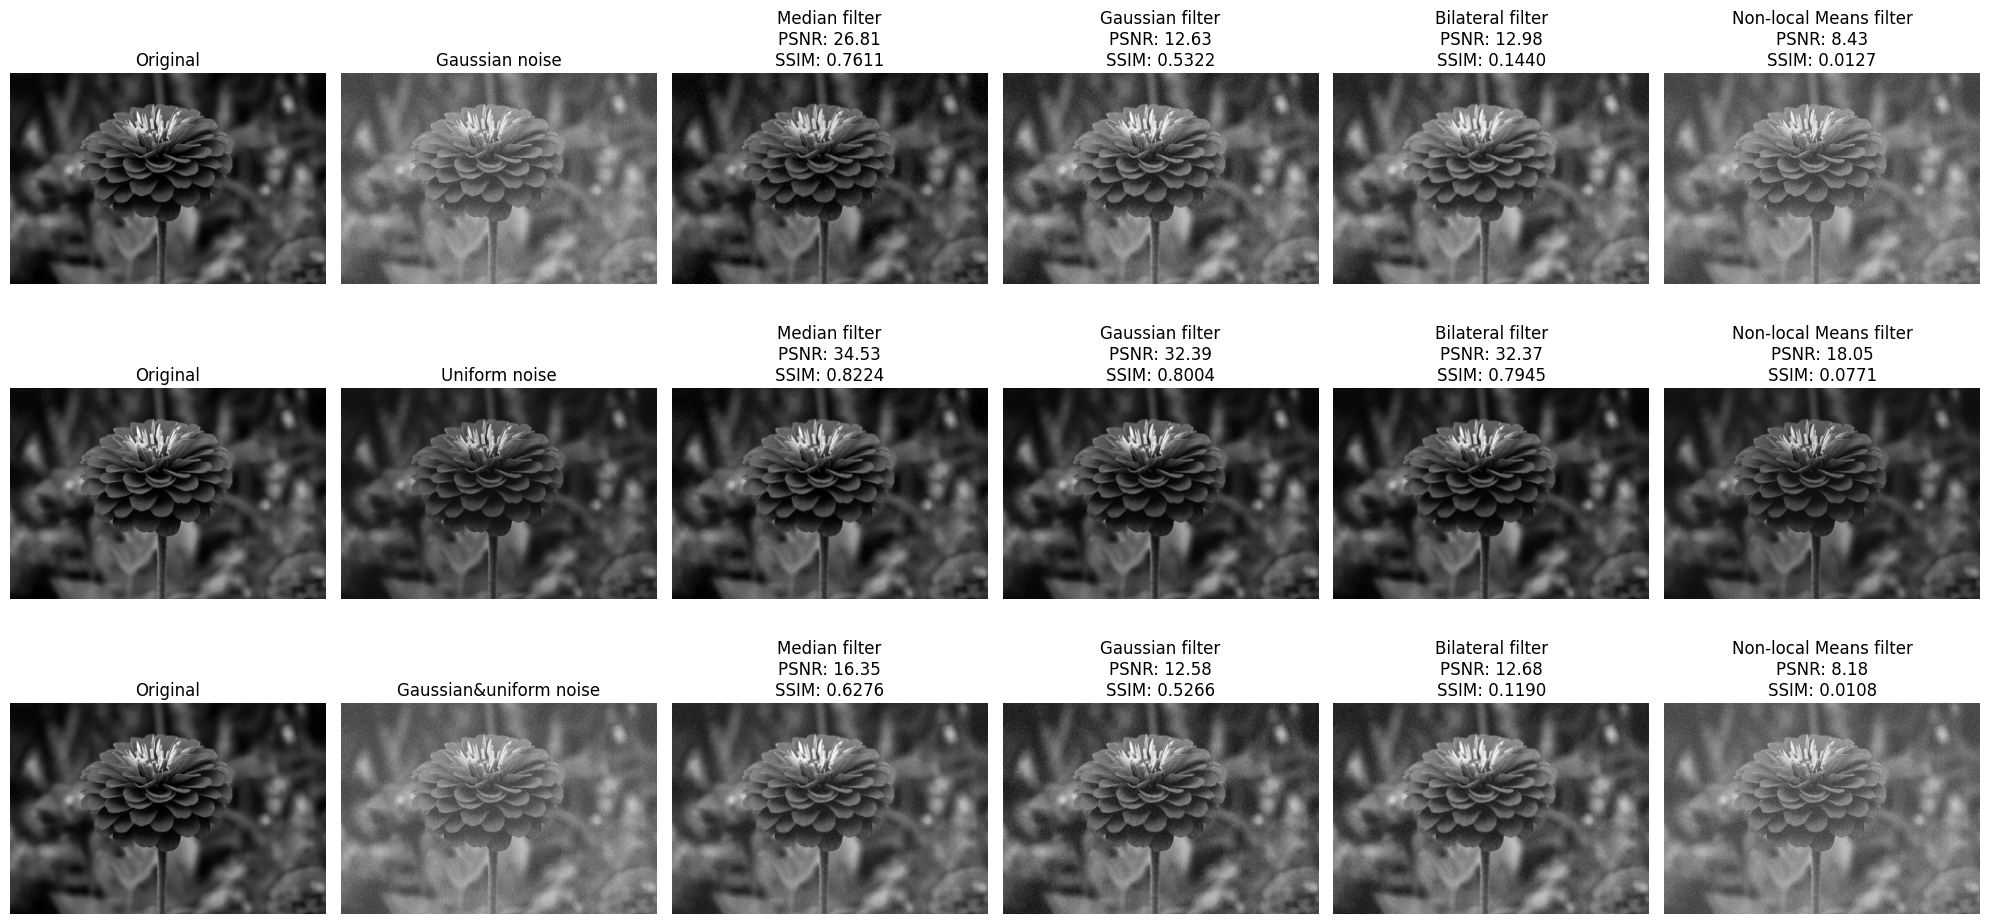


RESULTS:
--------------------------------------------------------------------------------
The best filter for gaussian noise: Median (gaussian noise, kernel=21)
  PSNR: 26.81, SSIM: 0.7611

The best filter for uniform noise: Median (uniform noise, kernel=21)
  PSNR: 34.53, SSIM: 0.8224

The best filter for gaussian&uniform noise: Median (gaussian&uniform noise, kernel=21)
  PSNR: 16.35, SSIM: 0.6276



In [107]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for row, (noise_name) in enumerate(noise_types):
    best_filters = get_best_filters(noise_name, best_results, results)
    plot_noise_type_results(axes[row], noise_name, noise_types[noise_name], best_filters, results, best_results)

plt.tight_layout()
plt.show()

best_overall = {}
for noise_type in ['gaussian', 'uniform', 'gaussian&uniform']:
    best_overall[noise_type] = max(
        [(key, psnr, ssim) for (nt, _), (key, psnr, ssim) in best_results.items() if nt == noise_type],
        key=lambda x: x[1]
    )

print("\nRESULTS:")
print("-" * 80)
for noise_type, (key, psnr, ssim) in best_overall.items():
    print(f"The best filter for {noise_type} noise: {key}")
    print(f"  PSNR: {psnr:.2f}, SSIM: {ssim:.4f}\n")